# spatial join

In [38]:
!pip install geopandas
!pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import numpy as np
#import useful packages
import pandas as pd
import geopandas as gpd
import matplotlib.pylab as plt
import rtree
import scipy as sp
import scipy.stats as sps
#make sure python plots are embedded in the notebook
%matplotlib inline 

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/noise_data_clean.csv')

In [42]:
df['Created_Date']= pd.to_datetime(df['Created_Date'])
df['Closed_Date']= pd.to_datetime(df['Closed_Date'])

In [43]:
df['Created_Date_year'] = df['Created_Date'].dt.year
df['Closed_Date_year'] = df['Closed_Date'].dt.year

In [44]:
#create geodataframe based on longitude and latitude
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf.head()

,Unnamed: 0,Unnamed: 0.1,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Complaint_Type,Resolution_Description,Resolution_Action_UpdatedDate,zipcode,Borough,Latitude,Longitude,Location,Processing_Time,Created_Date_year,Closed_Date_year,geometry
0,0,0,52494258,2021-11-12 23:32:03,2021-11-13 00:01:47,NYPD,New York City Police Department,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complai...,11/13/2021 12:01:53 AM,10009,MANHATTAN,40.728098,-73.980986,"(40.72809840521916, -73.98098598390919)",0 days 00:29:44,2021,2021,POINT (-73.98099 40.72810)
1,1,1,52494267,2021-11-12 22:51:56,2021-11-13 02:07:21,NYPD,New York City Police Department,Loud Music/Party,Noise - Residential,The Police Department responded to the complai...,11/13/2021 02:07:28 AM,11385,QUEENS,40.703420,-73.910624,"(40.70342006960225, -73.91062391218271)",0 days 03:15:25,2021,2021,POINT (-73.91062 40.70342)
2,2,2,52494269,2021-11-12 21:52:21,2021-11-12 22:46:15,NYPD,New York City Police Department,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complai...,11/12/2021 10:46:20 PM,10012,MANHATTAN,40.727491,-74.002594,"(40.727490610002285, -74.00259410868611)",0 days 00:53:54,2021,2021,POINT (-74.00259 40.72749)
3,3,3,52762434,2021-12-10 23:07:33,2021-12-10 23:16:17,NYPD,New York City Police Department,Banging/Pounding,Noise - Residential,The Police Department reviewed your complaint ...,12/10/2021 11:16:21 PM,10456,BRONX,40.838195,-73.911184,"(40.83819547525466, -73.91118371113687)",0 days 00:08:44,2021,2021,POINT (-73.91118 40.83820)
4,4,4,52762435,2021-12-10 10:33:53,2021-12-10 12:20:28,NYPD,New York City Police Department,Banging/Pounding,Noise - Residential,The Police Department responded to the complai...,12/10/2021 12:20:34 PM,11228,BROOKLYN,40.625777,-74.010364,"(40.62577708307177, -74.01036422375117)",0 days 01:46:35,2021,2021,POINT (-74.01036 40.62578)


In [45]:
gdf = gdf.dropna(subset = ['Latitude', 'Longitude'])

In [46]:
#Count of non-null values for every column 
gdf_columns = list(gdf.columns)
gdf[gdf_columns].count()

Unnamed: 0                       1980235
Unnamed: 0.1                     1980235
Unique_Key                       1980235
Created_Date                     1980235
Closed_Date                      1980235
Agency                           1980235
Agency_Name                      1980235
Descriptor                       1980233
Complaint_Type                   1980235
Resolution_Description           1980235
Resolution_Action_UpdatedDate    1980235
zipcode                          1980235
Borough                          1980235
Latitude                         1980235
Longitude                        1980235
Location                         1980235
Processing_Time                  1980235
Created_Date_year                1980235
Closed_Date_year                 1980235
geometry                         1980235
dtype: int64

In [47]:
#read shapefiles of NYC NTA
nta=gpd.read_file('/content/drive/MyDrive/Colab Notebooks/NTA map/geo_export_0b08d978-508b-4b2a-a82b-8141714e9545.shp')
nta.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((-73.94733 40.62917, -73.94687 40.626..."
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((-73.94193 40.70073, -73.94439 40.700..."
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((-73.89138 40.86170, -73.89106 40.861..."
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((-73.97605 40.63128, -73.97717 40.630..."
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((-73.90856 40.65210, -73.90945 40.651..."


In [48]:
nta.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [49]:
#!pip install -q condacolab -q

#import condacolab

#condacolab.install()

In [50]:
#spatial join(demographics)
gdf.crs = nta.crs
gdf311 = gpd.sjoin(gdf, nta, how="inner", op="intersects")
gdf311.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,Unnamed: 0,Unnamed: 0.1,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Complaint_Type,Resolution_Description,...,Closed_Date_year,geometry,index_right,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng
0,0,0,52494258,2021-11-12 23:32:03,2021-11-13 00:01:47,NYPD,New York City Police Department,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complai...,...,2021,POINT (-73.98099 40.72810),23,1.0,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632
7,7,7,52762458,2021-12-10 21:08:18,2021-12-10 21:49:12,NYPD,New York City Police Department,Loud Music/Party,Noise - Residential,The Police Department responded to the complai...,...,2021,POINT (-73.98917 40.72528),23,1.0,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632
41,43,123,46242992,2020-05-19 17:12:01,2020-05-19 17:35:00,NYPD,New York City Police Department,Loud Talking,Noise - Street/Sidewalk,The Police Department responded to the complai...,...,2020,POINT (-73.98922 40.73050),23,1.0,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632
134,141,456,52929198,2021-12-31 01:47:57,2021-12-31 02:30:19,NYPD,New York City Police Department,Loud Music/Party,Noise - Residential,The Police Department responded to the complai...,...,2021,POINT (-73.98769 40.72999),23,1.0,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632
138,145,465,52929216,2021-12-31 00:18:17,2021-12-31 00:30:49,NYPD,New York City Police Department,Loud Music/Party,Noise - Commercial,The Police Department responded to the complai...,...,2021,POINT (-73.98348 40.72615),23,1.0,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632


In [51]:
gdf311_2019=gdf311[gdf311['Created_Date_year'] == 2019]
gdf311_2020=gdf311[gdf311['Created_Date_year'] == 2020]
gdf311_2021=gdf311[gdf311['Created_Date_year'] == 2021]

In [52]:
gdf311_2019.head()

,Unnamed: 0,Unnamed: 0.1,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Complaint_Type,Resolution_Description,...,Closed_Date_year,geometry,index_right,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng
17147,17871,41197,43356004,2019-07-23 22:02:57,2019-07-23 23:48:10,NYPD,New York City Police Department,Loud Music/Party,Noise - Park,The Police Department responded to the complai...,...,2019,POINT (-73.97991 40.72687),23,1.0,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632
17248,17977,41337,43524941,2019-08-11 19:12:51,2019-08-11 20:34:13,NYPD,New York City Police Department,Loud Music/Party,Noise - Park,The Police Department responded to the complai...,...,2019,POINT (-73.98822 40.73038),23,1.0,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632
41936,45176,95036,43641293,2019-08-25 22:16:10,2019-08-26 00:01:28,NYPD,New York City Police Department,Banging/Pounding,Noise - Residential,The Police Department responded to the complai...,...,2019,POINT (-73.98702 40.72948),23,1.0,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632
42397,45683,95818,43365027,2019-07-23 21:06:16,2019-07-23 23:54:39,NYPD,New York City Police Department,Loud Music/Party,Noise - Park,The Police Department responded to the complai...,...,2019,POINT (-73.98033 40.72628),23,1.0,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632
84392,90194,184684,43176863,2019-07-02 21:22:45,2019-07-02 22:45:19,NYPD,New York City Police Department,Loud Music/Party,Noise - Commercial,The Police Department responded to the complai...,...,2019,POINT (-73.98128 40.72822),23,1.0,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632


In [53]:
table = pd.pivot_table(gdf311, values=['Unique_Key'], index =['ntacode'], aggfunc = len)
nta311 = pd.merge(nta,table,left_on='ntacode',right_index=True)
nta311.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry,Unique_Key
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((-73.94733 40.62917, -73.94687 40.626...",5316
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((-73.94193 40.70073, -73.94439 40.700...",20960
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((-73.89138 40.86170, -73.89106 40.861...",12254
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((-73.97605 40.63128, -73.97717 40.630...",4167
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((-73.90856 40.65210, -73.90945 40.651...",6815


In [54]:
table_2019 = pd.pivot_table(gdf311_2019, values=['Unique_Key'], index =['ntacode'], aggfunc = len)
nta311_2019 = pd.merge(nta,table_2019,left_on='ntacode',right_index=True)
nta311_2019.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry,Unique_Key
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((-73.94733 40.62917, -73.94687 40.626...",1452
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((-73.94193 40.70073, -73.94439 40.700...",5950
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((-73.89138 40.86170, -73.89106 40.861...",2519
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((-73.97605 40.63128, -73.97717 40.630...",1236
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((-73.90856 40.65210, -73.90945 40.651...",1554


In [55]:
table_2020 = pd.pivot_table(gdf311_2020, values=['Unique_Key'], index =['ntacode'], aggfunc = len)
nta311_2020 = pd.merge(nta,table_2020,left_on='ntacode',right_index=True)
nta311_2020.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry,Unique_Key
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((-73.94733 40.62917, -73.94687 40.626...",1944
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((-73.94193 40.70073, -73.94439 40.700...",7415
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((-73.89138 40.86170, -73.89106 40.861...",4680
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((-73.97605 40.63128, -73.97717 40.630...",1447
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((-73.90856 40.65210, -73.90945 40.651...",2616


In [56]:
table_2021 = pd.pivot_table(gdf311_2021, values=['Unique_Key'], index =['ntacode'], aggfunc = len)
nta311_2021 = pd.merge(nta,table_2021,left_on='ntacode',right_index=True)
nta311_2021.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry,Unique_Key
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((-73.94733 40.62917, -73.94687 40.626...",1920
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((-73.94193 40.70073, -73.94439 40.700...",7595
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((-73.89138 40.86170, -73.89106 40.861...",5055
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((-73.97605 40.63128, -73.97717 40.630...",1484
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((-73.90856 40.65210, -73.90945 40.651...",2645


In [57]:
nta311_2021.boroname.unique()

array(['Brooklyn', 'Bronx', 'Queens', 'Manhattan', 'Staten Island'],
      dtype=object)

In [58]:
noise_complaints_manhattan= nta311_2021[nta311_2021['boroname']=='Manhattan']
noise_complaints_brooklyn= nta311_2021[nta311_2021['boroname']=='Brooklyn']
noise_complaints_bronx= nta311_2021[nta311_2021['boroname']=='Bronx']
noise_complaints_queens= nta311_2021[nta311_2021['boroname']=='Queens']
noise_complaints_staten= nta311_2021[nta311_2021['boroname']=='Staten Island']

In [59]:
pip install matplotlib_scalebar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
noise_complaints_manhattan = noise_complaints_manhattan.to_crs(32618)
noise_complaints_brooklyn = noise_complaints_brooklyn.to_crs(32618)
noise_complaints_bronx = noise_complaints_bronx.to_crs(32618)
noise_complaints_queens = noise_complaints_queens.to_crs(32618)
noise_complaints_staten = noise_complaints_staten.to_crs(32618)

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:640: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


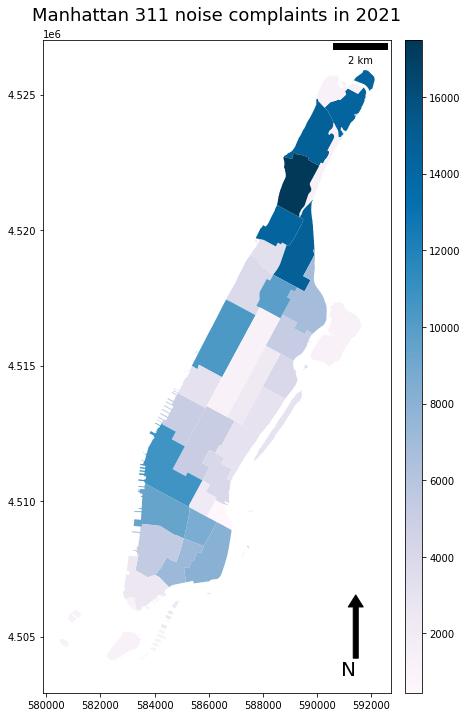

In [61]:
#resize plot
from pylab import rcParams
rcParams['figure.figsize'] = 30, 13
import geopandas as gpd
from matplotlib_scalebar.scalebar import ScaleBar


#plt.subplot(1, 3, 1)
#now color the manhattan zones based on the number of 311 noise complaints
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

ax.set_title("Manhattan 311 noise complaints in 2021", fontsize=18,pad = 20)
noise_complaints_manhattan.plot(axes=ax, column='Unique_Key', legend = True, cmap='PuBu',cax=cax)

ax.add_artist(ScaleBar(1))
x, y, arrow_length = 0.9, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='right', va='top', fontsize=20,
            xycoords=ax.transAxes)

plt.savefig('./Pic 2021 manhattan',dpi=500,bbox_inches = 'tight',transparent = True)

In [ ]:
#resize plot
from pylab import rcParams
rcParams['figure.figsize'] = 30, 13


#plt.subplot(1, 3, 1)
#now color the manhattan zones based on the number of 311 noise complaints
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

ax.set_title("Brooklyn 311 noise complaints in 2021", fontsize=18,pad =20)
noise_complaints_brooklyn.plot(axes=ax, column='Unique_Key', legend = True, cmap='PuBu',cax=cax)
ax.add_artist(ScaleBar(1))
x, y, arrow_length = 0.9, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='right', va='top', fontsize=20,
            xycoords=ax.transAxes)

plt.savefig('./Pic 2021 brooklyn',dpi=500,bbox_inches = 'tight',transparent = True)

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:640: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


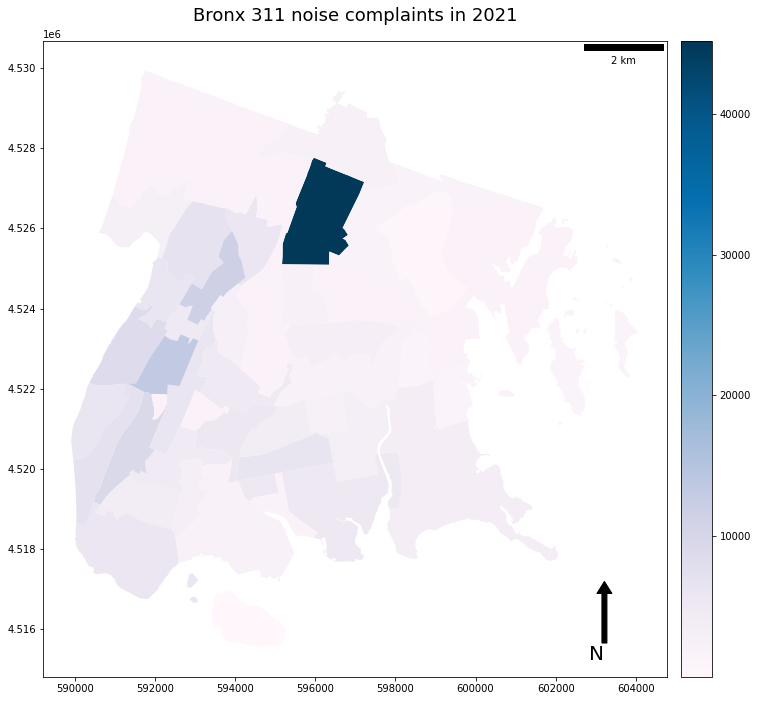

In [63]:
rcParams['figure.figsize'] = 30, 13

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

ax.set_title("Bronx 311 noise complaints in 2021", fontsize=18,pad =20)
noise_complaints_bronx.plot(axes=ax, column='Unique_Key', legend = True, cmap='PuBu',cax=cax)
ax.add_artist(ScaleBar(1))
x, y, arrow_length = 0.9, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='right', va='top', fontsize=20,
            xycoords=ax.transAxes)


plt.savefig('./Pic 2021 bronx',dpi=500,bbox_inches = 'tight',transparent = True)

In [ ]:
rcParams['figure.figsize'] = 30, 13

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

ax.set_title("Queens 311 noise complaints in 2021", fontsize=18,pad =20)
noise_complaints_queens.plot(axes=ax, column='Unique_Key', legend = True, cmap='PuBu',cax=cax)
ax.add_artist(ScaleBar(1))
x, y, arrow_length = 0.9, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='right', va='top', fontsize=20,
            xycoords=ax.transAxes)


plt.savefig('./Pic 2021 queens',dpi=500,bbox_inches = 'tight',transparent = True)

In [ ]:
rcParams['figure.figsize'] = 30, 13


from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

ax.set_title("Staten Island 311 noise complaints in 2021", fontsize=18,pad =20)
noise_complaints_staten.plot(axes=ax, column='Unique_Key', legend = True, cmap='PuBu',cax=cax)

ax.add_artist(ScaleBar(1))
x, y, arrow_length = 0.9, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='right', va='top', fontsize=20,
            xycoords=ax.transAxes)

plt.savefig('./Pic 2021 staten island',dpi=500,bbox_inches = 'tight',transparent = True)

In [ ]:

#now color the NTA zones based on the number of 311 noise complaints
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

nta311 = nta311.to_crs(32618)

ax.set_title("311 noise complaints", fontsize=18)
nta311.plot(axes=ax, column='Unique_Key', legend = True, cmap='PuBu',cax=cax)



ax.add_artist(ScaleBar(1))
x, y, arrow_length = 0.9, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='right', va='top', fontsize=20,
            xycoords=ax.transAxes)

plt.savefig('./Pic 311 map',dpi=500,bbox_inches = 'tight',transparent = True)

In [ ]:
#now color the NTA zones based on the number of 311 noise complaints
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

nta311_2019 = nta311_2019.to_crs(32618)

ax.set_title("311 noise complaints in 2019", fontsize=18)
nta311_2019.plot(axes=ax, column='Unique_Key', legend = True, cmap='PuBu',cax=cax)

ax.add_artist(ScaleBar(1))
x, y, arrow_length = 0.9, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='right', va='top', fontsize=20,
            xycoords=ax.transAxes)

plt.savefig('./Pic 311 map in 2019',dpi=500,bbox_inches = 'tight',transparent = True)



/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:640: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


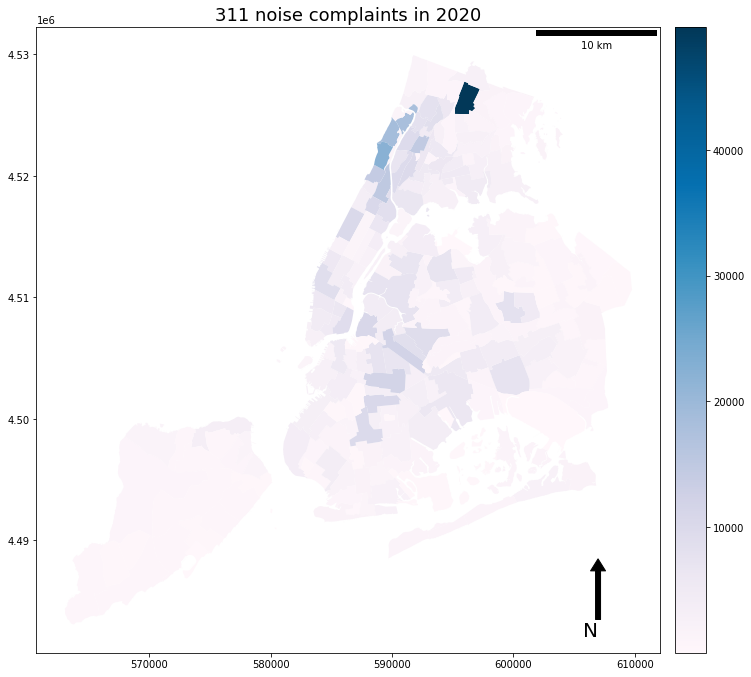

In [68]:
#now color the NTA zones based on the number of 311 noise complaints
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

nta311_2020 = nta311_2020.to_crs(32618)

ax.set_title("311 noise complaints in 2020", fontsize=18)
nta311_2020.plot(axes=ax, column='Unique_Key', legend = True, cmap='PuBu',cax=cax)
ax.add_artist(ScaleBar(1))
x, y, arrow_length = 0.9, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='right', va='top', fontsize=20,
            xycoords=ax.transAxes)

plt.savefig('./Pic 311 map in 2020',dpi=500,bbox_inches = 'tight',transparent = True)

In [ ]:
#now color the NTA zones based on the number of 311 noise complaints
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

nta311_2021 = nta311_2021.to_crs(32618)

ax.set_title("311 noise complaints in 2021", fontsize=18)
nta311_2021.plot(axes=ax, column='Unique_Key', legend = True, cmap='PuBu',cax=cax)

ax.add_artist(ScaleBar(1))
x, y, arrow_length = 0.9, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='right', va='top', fontsize=20,
            xycoords=ax.transAxes)


plt.savefig('./Pic 311 map in 2021',dpi=500,bbox_inches = 'tight',transparent = True)

In [70]:
#as values vary widely try log-scale
#import numpy as np

#nta311['log_unique_key'] = np.log(nta311.Unique_Key)

#from mpl_toolkits.axes_grid1 import make_axes_locatable
#fig, ax = plt.subplots(1, figsize=(12, 12))
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.2)

#ax.set_title("311 noise complaints(Log)", fontsize=18)
#nta311.plot(axes=ax, column='log_unique_key', legend = True, cmap='PuBu',cax=cax)



# MLR

In [ ]:
#read variables data 
variables = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/factors.csv')
variables.head()

,GeoType,GeogName,GeoID,Borough,total_population,age_under_18_percentage,female_percentage,white_race_percentage,Unemployed_percentage,below_poverty_percentage,Renter-occupied_rate,Less_than_high_school_graduate_percentage,disability_percentage
0,NTA2010,Bath Beach,BK27,Brooklyn,33163,21.42,49.7,43.7,7.1,14.3,60.9,23.0,10.4
1,NTA2010,Bay Ridge,BK31,Brooklyn,79134,19.09,52.2,63.4,7.5,15.5,64.0,13.8,10.2
2,NTA2010,Bedford,BK75,Brooklyn,75318,29.71,51.6,35.1,12.5,34.4,81.5,21.7,10.2
3,NTA2010,Bensonhurst East,BK29,Brooklyn,64267,19.87,51.3,46.5,8.5,19.3,65.5,25.1,10.4
4,NTA2010,Bensonhurst West,BK28,Brooklyn,91646,21.05,51.3,42.7,8.8,18.3,65.5,28.1,11.1


In [72]:
noise_y = nta311[['ntacode','Unique_Key']]
noise_y

,ntacode,Unique_Key
0,BK43,5316
1,BK75,20960
2,BX40,12254
3,BK88,4167
4,BK96,6815
...,...,...
190,BX63,21207
191,QN17,10573
192,QN99,4163
193,QN03,2294


In [73]:
noise_y.rename(columns = {'Unique_Key':'total_complaints_number'},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [74]:
noise_y

,ntacode,total_complaints_number
0,BK43,5316
1,BK75,20960
2,BX40,12254
3,BK88,4167
4,BK96,6815
...,...,...
190,BX63,21207
191,QN17,10573
192,QN99,4163
193,QN03,2294


In [ ]:
#add the variables columns to the noise dataframe
var_noise_X = pd.merge(noise_y,variables,left_on='ntacode',right_on='GeoID')
var_noise_X.head()

,ntacode,total_complaints_number,GeoType,GeogName,GeoID,Borough,total_population,age_under_18_percentage,female_percentage,white_race_percentage,Unemployed_percentage,below_poverty_percentage,Renter-occupied_rate,Less_than_high_school_graduate_percentage,disability_percentage
0,BK43,5316,NTA2010,Midwood,BK43,Brooklyn,53377,27.17,51.8,74.7,9.2,23.7,67.5,14.1,11.3
1,BK75,20960,NTA2010,Bedford,BK75,Brooklyn,75318,29.71,51.6,35.1,12.5,34.4,81.5,21.7,10.2
2,BX40,12254,NTA2010,Fordham South,BX40,The Bronx,28434,30.32,51.6,1.2,14.3,45.2,98.8,37.1,13.1
3,BK88,4167,NTA2010,Borough Park,BK88,Brooklyn,105913,39.34,49.0,75.7,5.7,38.3,68.8,27.1,8.3
4,BK96,6815,NTA2010,Rugby-Remsen Village,BK96,Brooklyn,55951,21.33,56.4,1.8,9.6,18.8,69.6,16.3,9.8


In [ ]:
# some basic statistics about the dataset
print("Number of missing values in the data is", var_noise_X.isnull().sum().sum())

Number of missing values in the data is 0


In [ ]:
var_noise_X.describe()

,total_complaints_number,total_population,age_under_18_percentage,female_percentage,white_race_percentage,Unemployed_percentage,below_poverty_percentage,Renter-occupied_rate,Less_than_high_school_graduate_percentage,disability_percentage
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,10425.640212,44719.322751,21.232487,52.407937,33.708995,8.742328,19.579894,64.469312,19.163492,10.785185
std,11169.738787,22175.792449,5.870854,2.450486,27.824065,3.444330,10.811633,22.333519,10.488707,3.408015
min,454.000000,1777.000000,5.120000,44.800000,0.400000,2.600000,3.900000,13.000000,1.500000,3.700000
25%,3497.000000,27886.000000,18.200000,50.900000,6.800000,6.000000,11.200000,49.400000,11.300000,8.300000
50%,6931.000000,39144.000000,21.240000,52.200000,25.900000,8.100000,16.800000,67.500000,17.100000,10.200000
75%,13945.000000,55951.000000,24.230000,53.900000,61.300000,10.900000,26.700000,83.100000,27.100000,12.300000
max,98219.000000,134019.000000,47.930000,60.700000,94.800000,21.800000,53.500000,100.000000,54.200000,26.300000


In [77]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


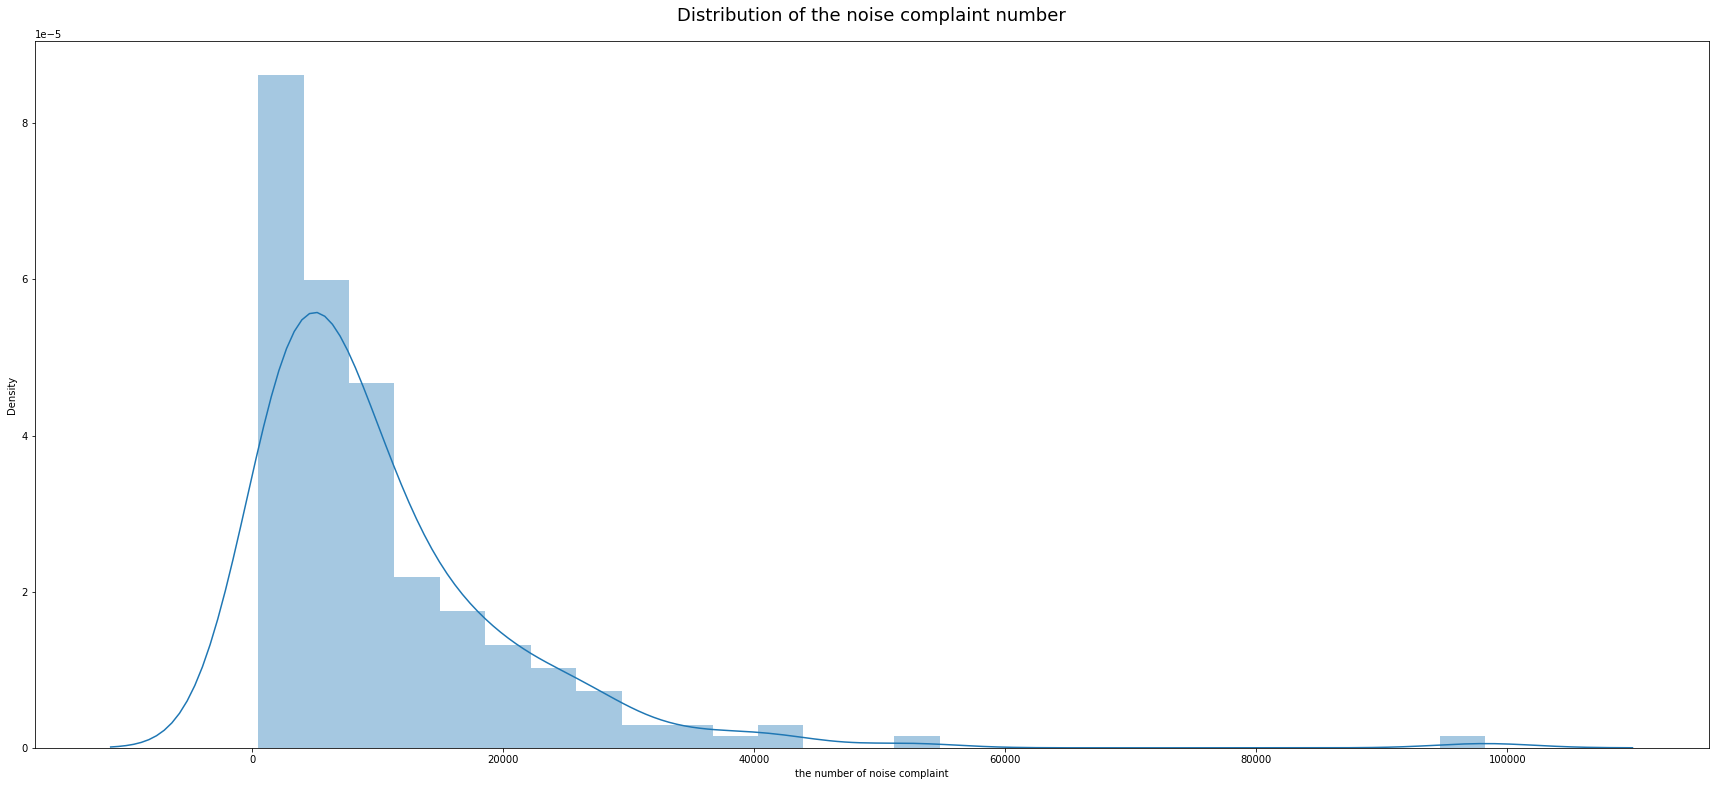

In [ ]:

#let's look at the distribution of the count 
sns.distplot(var_noise_X['total_complaints_number'], label='count')
plt.xlabel('the number of noise complaint')
plt.title('Distribution of the noise complaint number',fontsize=18,pad = 20)
plt.savefig('./Fig 0 distribution',dpi=500,bbox_inches = 'tight',transparent = True)

In [ ]:
var_noise_X['Complaint_number_Log'] = np.log(var_noise_X['total_complaints_number'])

In [ ]:
var_noise_X = var_noise_X.replace([np.inf, -np.inf, -0], 0)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


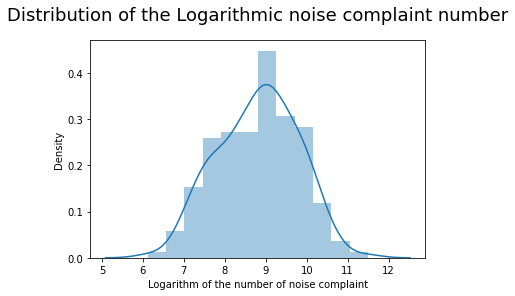

In [ ]:
#let's look at the distribution of the count 
sns.distplot(var_noise_X['Complaint_number_Log'], label='count')
plt.xlabel('Logarithm of the number of noise complaint')
plt.title('Distribution of the Logarithmic noise complaint number',fontsize=18,pad = 20)
plt.savefig('./Fig 0 distribution1',dpi=500,bbox_inches = 'tight',transparent = True)

In [ ]:
var_noise_X = var_noise_X.drop(['total_complaints_number'], axis=1)

# double check the result
var_noise_X.head()

,ntacode,GeoType,GeogName,GeoID,Borough,total_population,age_under_18_percentage,female_percentage,white_race_percentage,Unemployed_percentage,below_poverty_percentage,Renter-occupied_rate,Less_than_high_school_graduate_percentage,disability_percentage,Complaint_number_Log
0,BK43,NTA2010,Midwood,BK43,Brooklyn,53377,27.17,51.8,74.7,9.2,23.7,67.5,14.1,11.3,8.578476
1,BK75,NTA2010,Bedford,BK75,Brooklyn,75318,29.71,51.6,35.1,12.5,34.4,81.5,21.7,10.2,9.950371
2,BX40,NTA2010,Fordham South,BX40,The Bronx,28434,30.32,51.6,1.2,14.3,45.2,98.8,37.1,13.1,9.413608
3,BK88,NTA2010,Borough Park,BK88,Brooklyn,105913,39.34,49.0,75.7,5.7,38.3,68.8,27.1,8.3,8.334952
4,BK96,NTA2010,Rugby-Remsen Village,BK96,Brooklyn,55951,21.33,56.4,1.8,9.6,18.8,69.6,16.3,9.8,8.826881


In [ ]:
#drop unnecessary columns for regression
var_noise_X.drop('ntacode', axis=1, inplace=True)
var_noise_X.drop('GeoType', axis=1, inplace=True)
var_noise_X.drop('GeogName', axis=1, inplace=True)
var_noise_X.drop('GeoID', axis=1, inplace=True)
#noise_nta.drop('Total Population', axis=1, inplace=True)

In [ ]:
var_noise_X.head()

,Borough,total_population,age_under_18_percentage,female_percentage,white_race_percentage,Unemployed_percentage,below_poverty_percentage,Renter-occupied_rate,Less_than_high_school_graduate_percentage,disability_percentage,Complaint_number_Log
0,Brooklyn,53377,27.17,51.8,74.7,9.2,23.7,67.5,14.1,11.3,8.578476
1,Brooklyn,75318,29.71,51.6,35.1,12.5,34.4,81.5,21.7,10.2,9.950371
2,The Bronx,28434,30.32,51.6,1.2,14.3,45.2,98.8,37.1,13.1,9.413608
3,Brooklyn,105913,39.34,49.0,75.7,5.7,38.3,68.8,27.1,8.3,8.334952
4,Brooklyn,55951,21.33,56.4,1.8,9.6,18.8,69.6,16.3,9.8,8.826881


In [ ]:
var_noise = pd.get_dummies(var_noise_X)

In [ ]:
var_noise.head()

,total_population,age_under_18_percentage,female_percentage,white_race_percentage,Unemployed_percentage,below_poverty_percentage,Renter-occupied_rate,Less_than_high_school_graduate_percentage,disability_percentage,Complaint_number_Log,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island,Borough_The Bronx
0,53377,27.17,51.8,74.7,9.2,23.7,67.5,14.1,11.3,8.578476,1,0,0,0,0
1,75318,29.71,51.6,35.1,12.5,34.4,81.5,21.7,10.2,9.950371,1,0,0,0,0
2,28434,30.32,51.6,1.2,14.3,45.2,98.8,37.1,13.1,9.413608,0,0,0,0,1
3,105913,39.34,49.0,75.7,5.7,38.3,68.8,27.1,8.3,8.334952,1,0,0,0,0
4,55951,21.33,56.4,1.8,9.6,18.8,69.6,16.3,9.8,8.826881,1,0,0,0,0


#### summary scatter plot

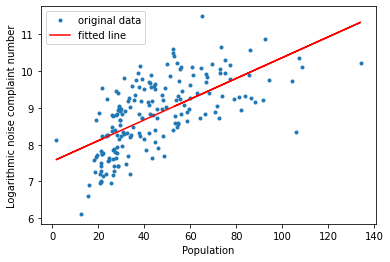

In [ ]:
#plt.figure(figsize=(15,15))
#sns.pairplot(preliminary,kind='reg')

#plt.figure(figsize=(6, 5),dpi=100)

#plt.subplot(1, 3, 1)
X = var_noise['total_population']
Y = var_noise['Complaint_number_Log']

plt.xlabel('Population')
plt.ylabel('Logarithmic noise complaint number')

a = plt.plot(X,Y,'.', label='original data')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label = 'fitted line') # Plot the regression line.
plt.legend()

plt.savefig('./Fig 1 scatter plot1',dpi=500,bbox_inches = 'tight',transparent = True)

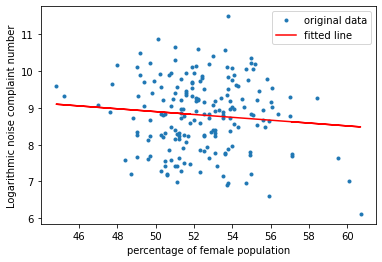

In [ ]:
#plt.subplot(1, 3, 2)
X = var_noise['female_percentage']
Y = var_noise['Complaint_number_Log']

plt.xlabel('percentage of female population')
plt.ylabel('Logarithmic noise complaint number')

a = plt.plot(X,Y,'.', label='original data')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label = 'fitted line') # Plot the regression line.
plt.legend()

plt.savefig('./Fig 1 scatter plot2',dpi=500,bbox_inches = 'tight',transparent = True)

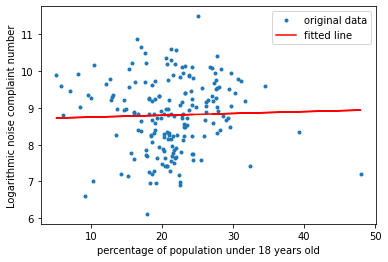

In [ ]:
#plt.subplot(1, 3, 3)
X = var_noise['age_under_18']
Y = var_noise['Complaint_number_Log']

plt.xlabel('percentage of population under 18 years old')
plt.ylabel('Logarithmic noise complaint number')

a = plt.plot(X,Y,'.', label='original data')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label = 'fitted line') # Plot the regression line.
plt.legend()
plt.savefig('./Fig 1 scatter plot3',dpi=500,bbox_inches = 'tight',transparent = True)

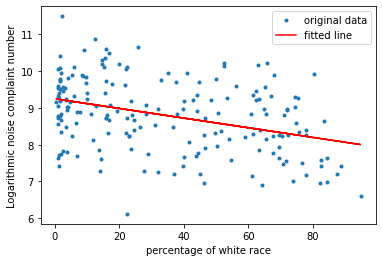

In [ ]:


#plt.subplot(1, 3, 1)
X = var_noise['white_ethic_percentage']
Y = var_noise['Complaint_number_Log']

plt.xlabel('percentage of white race')
plt.ylabel('Logarithmic noise complaint number')

a = plt.plot(X,Y,'.', label='original data')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label = 'fitted line') # Plot the regression line.    
plt.legend()

plt.legend()

plt.savefig('./Fig 1 scatter plot4',dpi=500,bbox_inches = 'tight',transparent = True)

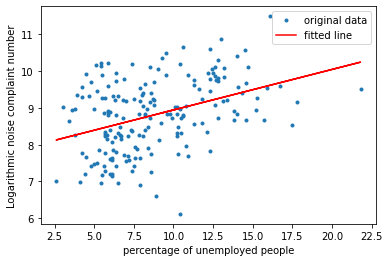

In [ ]:

#plt.subplot(1, 3, 2)
X = var_noise['Unemployed_percentage']
Y = var_noise['Complaint_number_Log']

plt.xlabel('percentage of unemployed people')
plt.ylabel('Logarithmic noise complaint number')

a = plt.plot(X,Y,'.', label='original data')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label = 'fitted line') # Plot the regression line.
plt.legend()
plt.savefig('./Fig 1 scatter plot5',dpi=500,bbox_inches = 'tight',transparent = True)

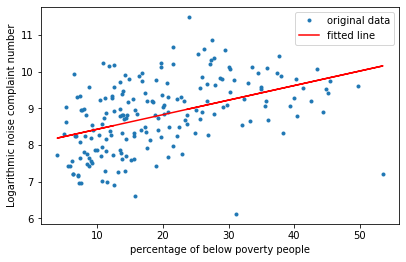

In [ ]:

#plt.subplot(1, 3, 3)
X = var_noise['below_poverty_percentage ']
Y = var_noise['Complaint_number_Log']

plt.xlabel('percentage of below poverty people')
plt.ylabel('Logarithmic noise complaint number')

a = plt.plot(X,Y,'.', label='original data')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label = 'fitted line') # Plot the regression line.
plt.legend()
plt.tight_layout(pad=2)

plt.savefig('./Fig 1 scatter plot6',dpi=500,bbox_inches = 'tight',transparent = True)

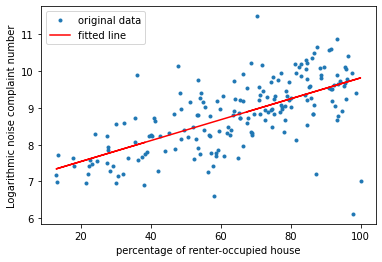

In [ ]:

#plt.subplot(1, 3, 1)
X = var_noise['Renter-occupied_rate']
Y = var_noise['Complaint_number_Log']

plt.xlabel('percentage of renter-occupied house')
plt.ylabel('Logarithmic noise complaint number')

a = plt.plot(X,Y,'.', label='original data')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label = 'fitted line') # Plot the regression line.
plt.legend()


plt.savefig('./Fig 1 scatter plot7',dpi=500,bbox_inches = 'tight',transparent = True)

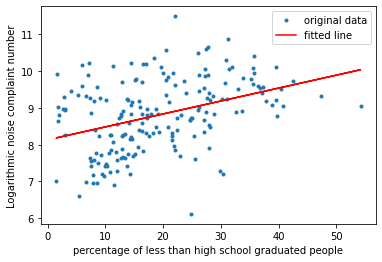

In [ ]:
X = var_noise['Less_than_high_school_graduate_percentage']
Y = var_noise['Complaint_number_Log']

plt.xlabel('percentage of less than high school graduated people')
plt.ylabel('Logarithmic noise complaint number')

a = plt.plot(X,Y,'.', label='original data')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label = 'fitted line') # Plot the regression line.
plt.legend()


plt.savefig('./Fig 1 scatter plot8',dpi=500,bbox_inches = 'tight',transparent = True)

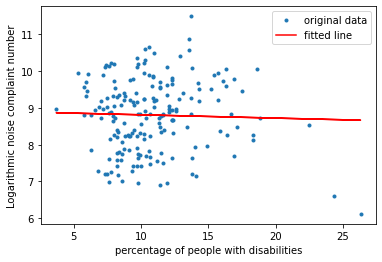

In [ ]:
X = var_noise['disability_percentage']
Y = var_noise['Complaint_number_Log']

plt.xlabel('percentage of people with disabilities')
plt.ylabel('Logarithmic noise complaint number')

a = plt.plot(X,Y,'.', label='original data')

slope, intercept, r_value, p_value, std_err = sps.linregress(X, Y) 

b = plt.plot(X, X*slope + intercept, 'r', label = 'fitted line') # Plot the regression line.
plt.legend()

plt.savefig('./Fig 1 scatter plot9',dpi=500,bbox_inches = 'tight',transparent = True)

In [ ]:
dfcenter = var_noise-var_noise.mean()
dfnorm = (var_noise-var_noise.mean())/var_noise.std()

print(dfnorm)

     total_population  age_under_18_percentage  female_percentage  \
0            0.390411                 1.011354          -0.248088   
1            1.379823                 1.444000          -0.329705   
2           -0.734374                 1.547903          -0.329705   
3            2.759481                 3.084307          -1.390718   
4            0.506484                 0.016610           1.629090   
..                ...                      ...                ...   
184          2.153550                -0.814615          -0.941828   
185         -0.251415                 1.619443           1.384241   
186         -0.330285                 1.064158          -0.166472   
187          1.885465                -0.521642           0.404844   
188         -1.029019                 0.532719           1.914748   

     white_race_percentage  Unemployed_percentage  below_poverty_percentage   \
0                 1.473221               0.132877                   0.381081   
1          

In [ ]:
dfnorm.describe()

,total_population,age_under_18_percentage,female_percentage,white_race_percentage,Unemployed_percentage,below_poverty_percentage,Renter-occupied_rate,Less_than_high_school_graduate_percentage,disability_percentage,Complaint_number_Log,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island,Borough_The Bronx
count,1.890000e+02,1.890000e+02,1.890000e+02,189.000000,1.890000e+02,1.890000e+02,1.890000e+02,1.890000e+02,1.890000e+02,1.890000e+02,1.890000e+02,1.890000e+02,1.890000e+02,1.890000e+02,1.890000e+02
mean,-1.127846e-16,-6.814067e-16,-1.597781e-15,0.000000,9.868649e-17,-2.537653e-16,-2.537653e-16,-1.315820e-16,-3.712492e-16,9.727668e-16,7.518971e-17,9.398713e-18,8.458842e-17,1.879743e-17,2.349678e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.936450e+00,-2.744488e+00,-3.104664e+00,-1.197129,-1.783316e+00,-1.450280e+00,-2.304577e+00,-1.684049e+00,-2.078977e+00,-2.749522e+00,-5.981714e-01,-4.159241e-01,-6.471668e-01,-3.235834e-01,-4.920702e-01
25%,-7.590855e-01,-5.165325e-01,-6.153621e-01,-0.967112,-7.961861e-01,-7.750813e-01,-6.747397e-01,-7.497104e-01,-7.292178e-01,-6.619913e-01,-5.981714e-01,-4.159241e-01,-6.471668e-01,-3.235834e-01,-4.920702e-01
50%,-2.514148e-01,1.279750e-03,-8.485520e-02,-0.280656,-1.864885e-01,-2.571207e-01,1.357013e-01,-1.967347e-01,-1.717085e-01,3.751016e-02,-5.981714e-01,-4.159241e-01,-6.471668e-01,-3.235834e-01,-4.920702e-01
75%,5.064837e-01,5.105754e-01,6.088846e-01,0.991624,6.264416e-01,6.585597e-01,8.342030e-01,7.566717e-01,4.444860e-01,7.523681e-01,1.662916e+00,-4.159241e-01,1.537021e+00,-3.235834e-01,-4.920702e-01
max,4.026899e+00,4.547467e+00,3.383844e+00,2.195618,3.791063e+00,3.137371e+00,1.590913e+00,3.340403e+00,4.552449e+00,2.748399e+00,1.662916e+00,2.391564e+00,1.537021e+00,3.074042e+00,2.021478e+00


#### correlation matrix

In [75]:
variables_matrix = pd.read_csv('https://raw.githubusercontent.com/Hannahzhu1/FSDS-data/main/factors_matrix.csv')

variables_matrix = pd.merge(noise_y,variables_matrix,left_on='ntacode',right_on='GeoID')
variables_matrix['log Complaint number'] = np.log(variables_matrix['total_complaints_number'])
variables_matrix = variables_matrix.drop(['total_complaints_number'], axis=1)
variables_matrix.drop('ntacode', axis=1, inplace=True)
variables_matrix.drop('GeoType', axis=1, inplace=True)
variables_matrix.drop('GeogName', axis=1, inplace=True)
variables_matrix.drop('GeoID', axis=1, inplace=True)
dfcenter = variables_matrix-variables_matrix.mean()
variables_matrix_norm = (variables_matrix-variables_matrix.mean())/variables_matrix.std()

print(variables_matrix_norm)

    Borough  CvLFUEm2P    CvNIDP  EA_LTHSGraP      FemP    PBwPvP  PopU181P  \
0       NaN   0.132877  0.151060    -0.482757 -0.248088  0.381081  1.011354   
1       NaN   1.090973 -0.171709     0.241832 -0.329705  1.370756  1.444000   
2       NaN   1.613571  0.679227     1.710078 -0.329705  2.369680  1.547903   
3       NaN  -0.883286 -0.729218     0.756672 -1.390718  1.731478  3.084307   
4       NaN   0.249010 -0.289079    -0.273007  1.629090 -0.072135  0.016610   
..      ...        ...       ...          ...       ...       ...       ...   
184     NaN   1.236139  0.825940     1.157102 -0.941828  0.723305 -0.814615   
185     NaN   1.032907  1.794245     1.528931  1.384241  1.907215  1.619443   
186     NaN   1.003873  1.442134     1.586135 -0.166472  1.638985  1.064158   
187     NaN  -0.883286  0.033690    -1.131073  0.404844 -0.775081 -0.521642   
188     NaN   0.452242 -0.289079    -0.492291  1.914748 -0.664090  0.532719   

       Pop_1P   ROcHU1P     WtNHP  log Complaint nu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()


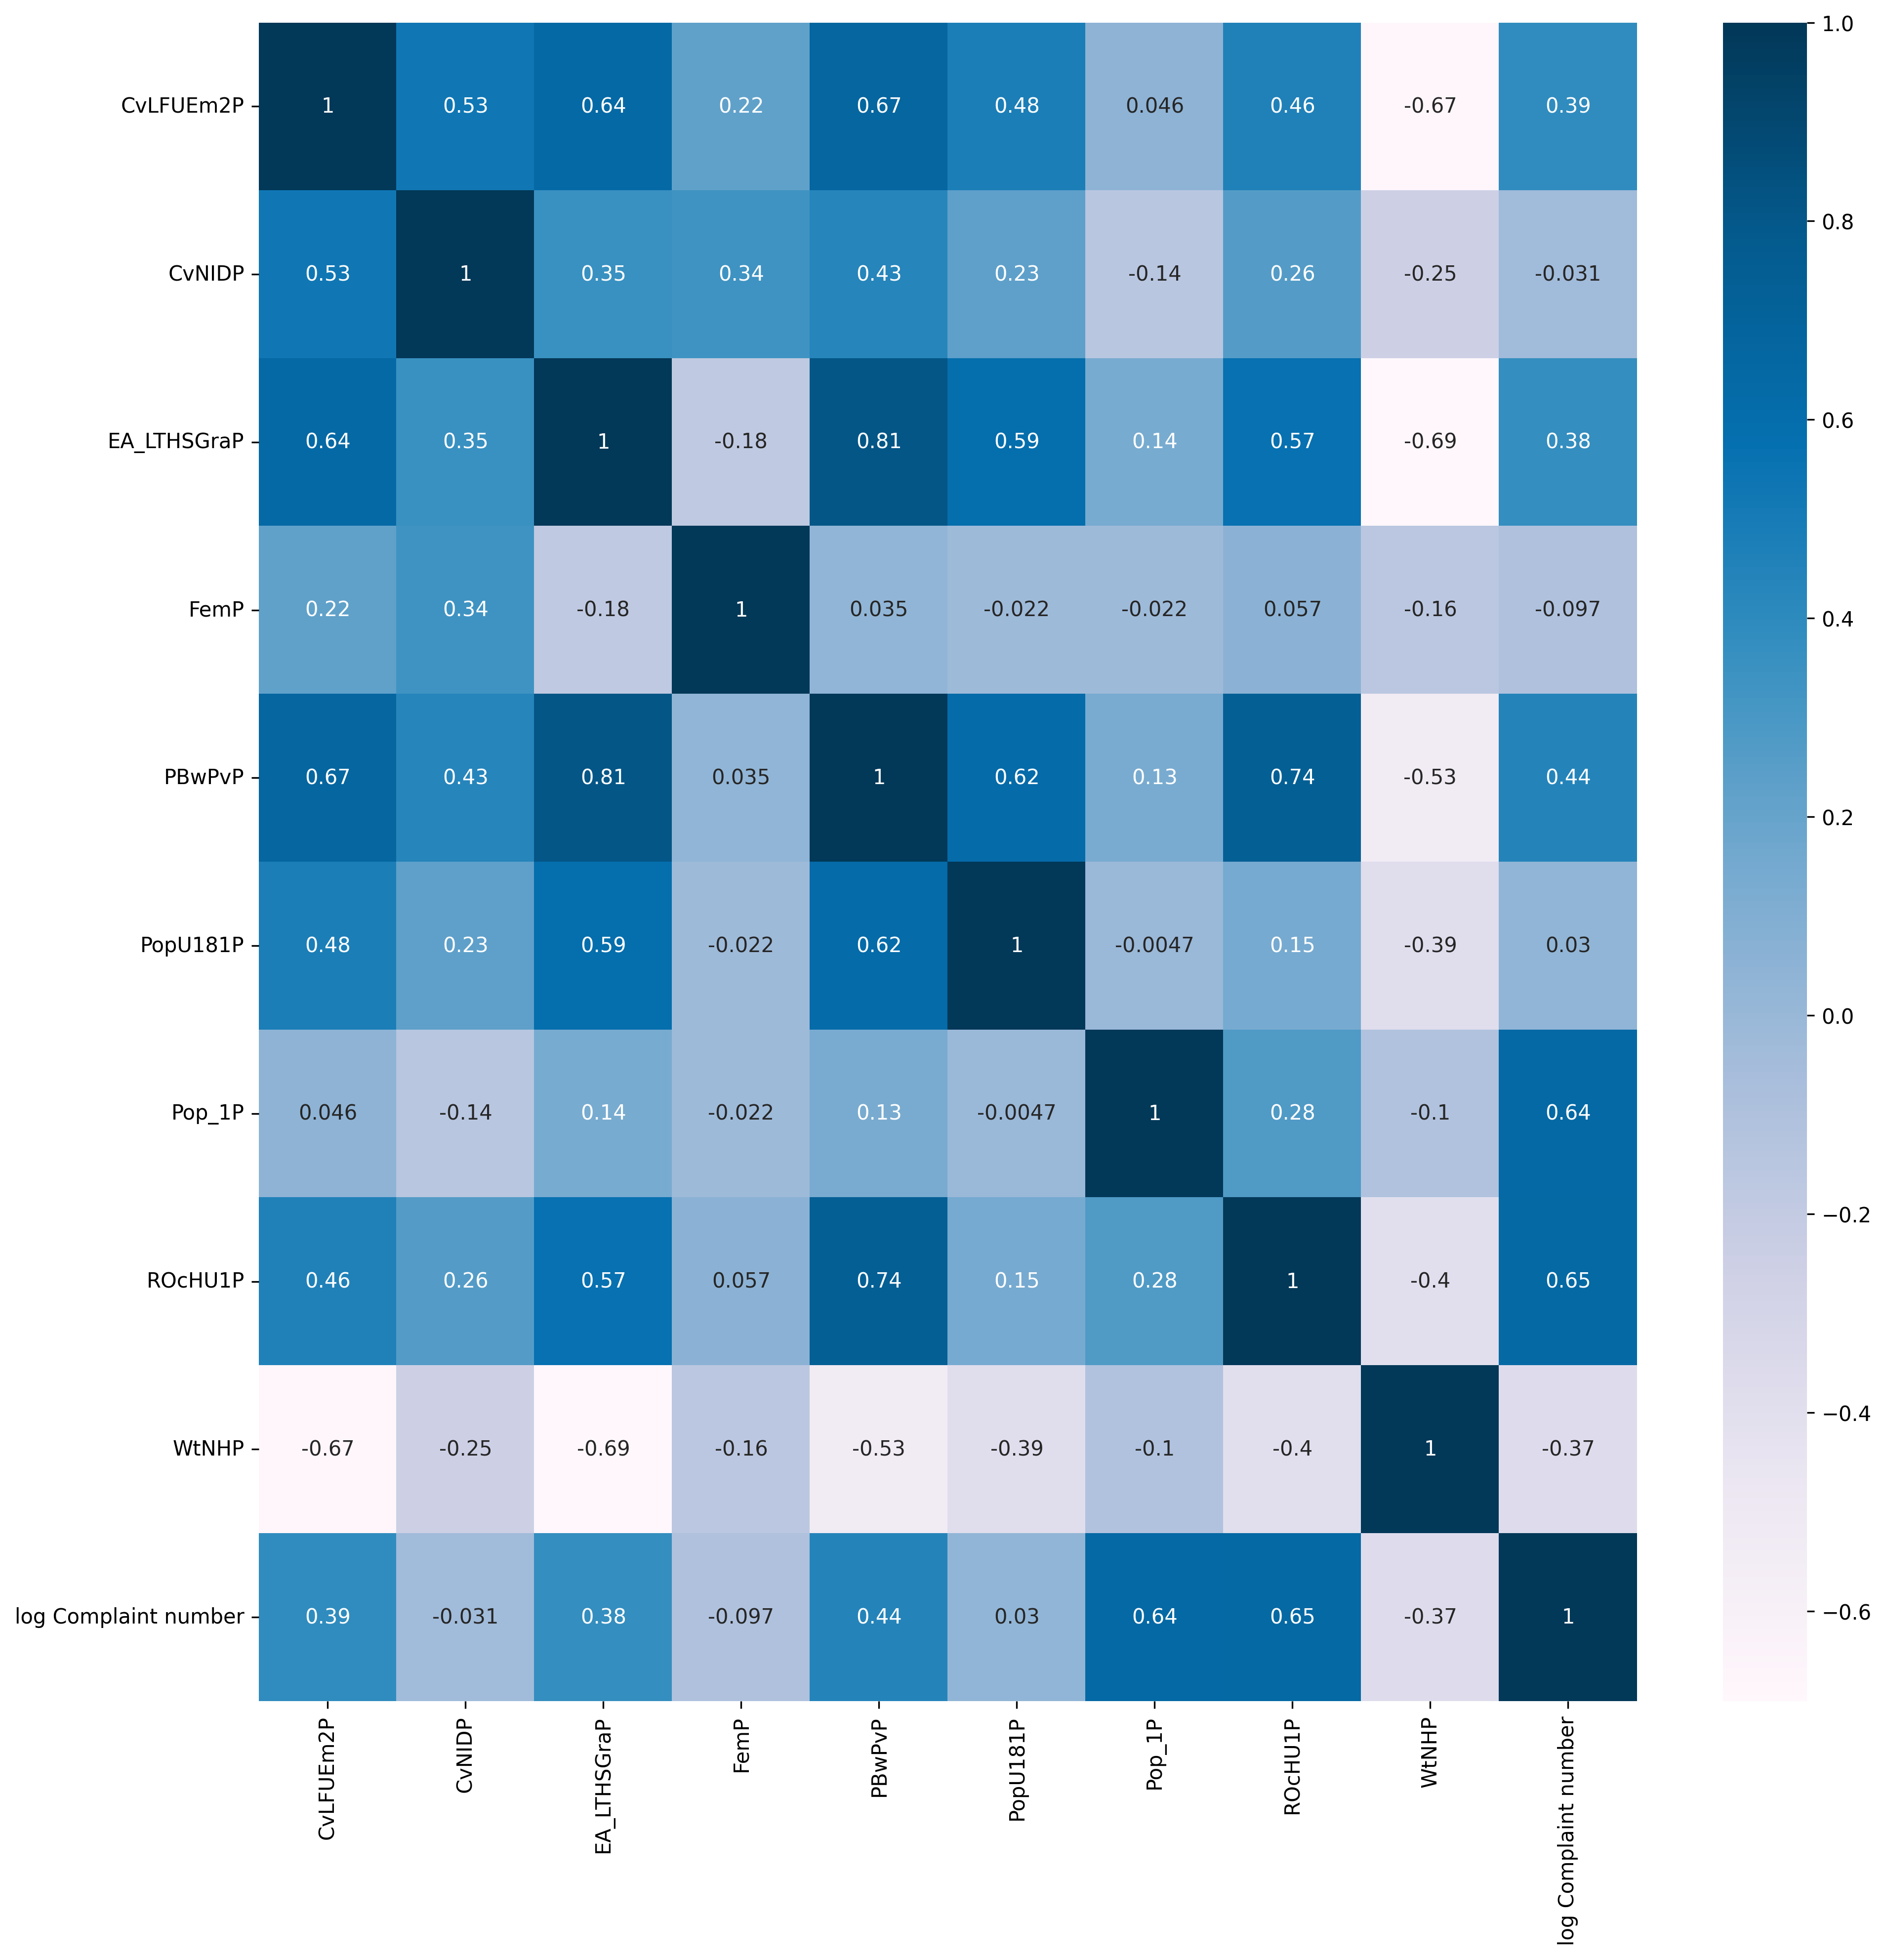

In [78]:

plt.figure(figsize=(15,15), dpi=300)
#sns.set(font_scale=1) 
res = sns.heatmap(variables_matrix_norm.corr(), annot=True,cmap='PuBu')
res.set_xticklabels(res.get_xmajorticklabels())
res.set_yticklabels(res.get_ymajorticklabels(), rotation = 360)
plt.savefig('./Fig 2 correlation matrix.png',dpi=500,bbox_inches = 'tight',transparent = True)

### fitting moder

In [ ]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=10):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [ ]:
# using VIF 

df_predictors_selected_VIF = drop_column_using_vif_(dfnorm.drop('Complaint_number_Log', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Dropping: Borough_Brooklyn
The columns remaining after VIF selection are:
Index(['total_population', 'age_under_18_percentage', 'female_percentage',
       'white_race_percentage', 'Unemployed_percentage',
       'below_poverty_percentage ', 'Renter-occupied_rate',
       'Less_than_high_school_graduate_percentage', 'disability_percentage',
       'Borough_Manhattan', 'Borough_Queens', 'Borough_Staten Island',
       'Borough_The Bronx'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
import statsmodels.api as sms
import statsmodels.api as sm

In [ ]:
model = sm.OLS(endog=dfnorm[['Complaint_number_Log']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Complaint_number_Log   R-squared:                       0.782
Model:                              OLS   Adj. R-squared:                  0.766
Method:                   Least Squares   F-statistic:                     48.31
Date:                  Sun, 21 Aug 2022   Prob (F-statistic):           6.81e-51
Time:                          14:37:51   Log-Likelihood:                -123.70
No. Observations:                   189   AIC:                             275.4
Df Residuals:                       175   BIC:                             320.8
Df Model:                            13                                         
Covariance Type:              nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      9.732e-16      0.035   2.77e-14      1.000      -0.069       0.069
total_population                              0.4942      0.041     12.097      0.000       0.414       0.575
age_under_18_percentage                      -0.1046      0.065     -1.611      0.109      -0.233       0.024
female_percentage                            -0.2159      0.047     -4.551      0.000      -0.309      -0.122
white_race_percentage                        -0.1731      0.066     -2.622      0.010      -0.303      -0.043
Unemployed_percentage                         0.3162      0.063      5.052      0.000       0.193       0.440
below_poverty_percentage                      0.0806      0.108      0.744      0.458      -0.133       0.295
Renter-occupied_rate                          0.3520      0.081      4.356      0.000       0.193       0.512
Less_than_high_school_graduate_percentage    -0.2264      0.089     -2.534      0.012      -0.403      -0.050
disability_percentage                        -0.1654      0.049     -3.379      0.001      -0.262      -0.069
Borough_Manhattan                             0.1496      0.050      2.971      0.003       0.050       0.249
Borough_Queens                                0.0076      0.055      0.139      0.889      -0.100       0.115
Borough_Staten Island                         0.0294      0.050      0.583      0.560      -0.070       0.129
Borough_The Bronx                             0.1672      0.049      3.383      0.001       0.070       0.265
==============================================================================
Omnibus:                       15.354   Durbin-Watson:                   1.572
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.643
Skew:                           0.310   Prob(JB):                     3.00e-08
Kurtosis:                       5.004   Cond. No.                         8.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

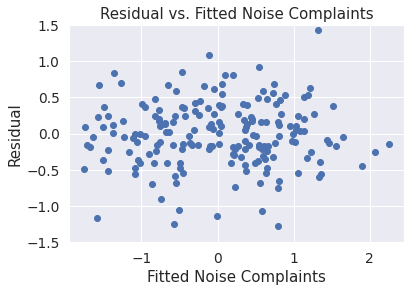

In [ ]:
# plot 
plt.scatter(model.fittedvalues, model.resid)
# adding title and labels
plt.xlabel('Fitted Noise Complaints')
plt.ylabel('Residual')
plt.ylim(-1.5,1.5)
plt.title('Residual vs. Fitted Noise Complaints')

plt.savefig('./Fig 3 residual analysis.png',dpi=500,bbox_inches = 'tight',transparent = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 2160x936 with 0 Axes>

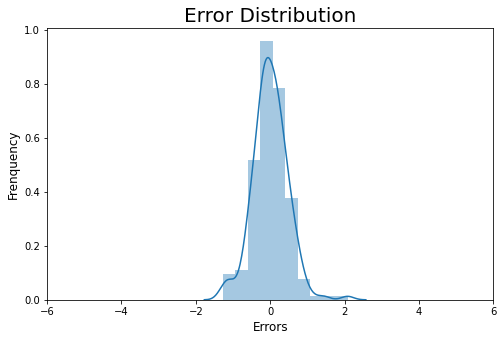

In [ ]:
# Plot the histogram of the error terms

fig = plt.figure()
plt.figure(figsize=(8,5))
sns.distplot((model.resid), bins = 10)
plt.title('Error Distribution', fontsize = 20)
plt.xlim([-6,6])
plt.xlabel('Errors', fontsize = 12)  
plt.ylabel('Frenquency', fontsize = 12) 

plt.savefig('./error_distribution.png',dpi=500,bbox_inches = 'tight',transparent = True)

In [ ]:
var_noise.drop('age_under_18', axis=1, inplace=True)

var_noise.drop('below_poverty_percentage ', axis=1, inplace=True)

In [ ]:
# using VIF 

df_predictors_selected_VIF = drop_column_using_vif_(var_noise.drop('Complaint_number_Log', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Dropping: Borough_Brooklyn
The columns remaining after VIF selection are:
Index(['total_population', 'female_percentage', 'white_ethic_percentage',
       'Unemployed_percentage', 'Renter-occupied_rate',
       'Less_than_high_school_graduate_percentage', 'disability_percentage',
       'Borough_Manhattan', 'Borough_Queens', 'Borough_Staten Island',
       'Borough_The Bronx'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
model = sm.OLS(endog=var_noise[['Complaint_number_Log']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Complaint_number_Log   R-squared:                       0.779
Model:                              OLS   Adj. R-squared:                  0.765
Method:                   Least Squares   F-statistic:                     56.65
Date:                  Fri, 19 Aug 2022   Prob (F-statistic):           4.31e-52
Time:                          03:21:35   Log-Likelihood:                -120.90
No. Observations:                   189   AIC:                             265.8
Df Residuals:                       177   BIC:                             304.7
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        11.5800      1.047     11.057      0.000       9.513      13.647
total_population                              0.0215      0.002     12.006      0.000       0.018       0.025
female_percentage                            -0.0894      0.019     -4.805      0.000      -0.126      -0.053
white_ethic_percentage                       -0.0064      0.002     -2.796      0.006      -0.011      -0.002
Unemployed_percentage                         0.0882      0.017      5.114      0.000       0.054       0.122
Renter-occupied_rate                          0.0175      0.003      6.370      0.000       0.012       0.023
Less_than_high_school_graduate_percentage    -0.0231      0.007     -3.437      0.001      -0.036      -0.010
disability_percentage                        -0.0424      0.014     -3.094      0.002      -0.069      -0.015
Borough_Manhattan                             0.5043      0.125      4.019      0.000       0.257       0.752
Borough_Queens                                0.0234      0.115      0.204      0.839      -0.203       0.250
Borough_Staten Island                         0.0969      0.163      0.593      0.554      -0.226       0.419
Borough_The Bronx                             0.3914      0.120      3.255      0.001       0.154       0.629
==============================================================================
Omnibus:                       13.078   Durbin-Watson:                   1.551
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               29.877
Skew:                           0.215   Prob(JB):                     3.25e-07
Kurtosis:                       4.900   Cond. No.                     3.18e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

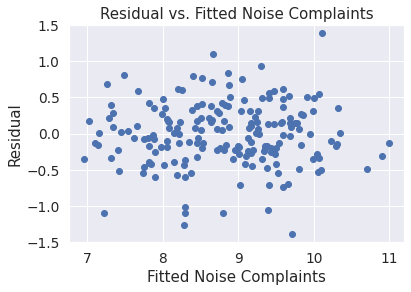

In [ ]:
# plot 
plt.scatter(model.fittedvalues, model.resid)
# adding title and labels
plt.xlabel('Fitted Noise Complaints')
plt.ylabel('Residual')
plt.ylim(-1.5,1.5)
plt.title('Residual vs. Fitted Noise Complaints')
plt.show()

In [ ]:
var_noise.head()

,total_population,female_percentage,white_ethic_percentage,Unemployed_percentage,Renter-occupied_rate,Less_than_high_school_graduate_percentage,disability_percentage,Complaint_number_Log,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island,Borough_The Bronx
0,53.377,51.8,74.7,9.2,67.5,14.1,11.3,8.578476,1,0,0,0,0
1,75.318,51.6,35.1,12.5,81.5,21.7,10.2,9.950371,1,0,0,0,0
2,28.434,51.6,1.2,14.3,98.8,37.1,13.1,9.413608,0,0,0,0,1
3,105.913,49.0,75.7,5.7,68.8,27.1,8.3,8.334952,1,0,0,0,0
4,55.951,56.4,1.8,9.6,69.6,16.3,9.8,8.826881,1,0,0,0,0


In [ ]:
dfcenter = var_noise-var_noise.mean()
dfnorm = (var_noise-var_noise.mean())/var_noise.std()

print(dfnorm)

     total_population  female_percentage  white_ethic_percentage  \
0            0.390411          -0.248088                1.473221   
1            1.379823          -0.329705                0.049993   
2           -0.734374          -0.329705               -1.168377   
3            2.759481          -1.390718                1.509161   
4            0.506484           1.629090               -1.146813   
..                ...                ...                     ...   
184          2.153550          -0.941828               -0.765848   
185         -0.251415           1.384241               -1.150407   
186         -0.330285          -0.166472               -1.143219   
187          1.885465           0.404844                0.704103   
188         -1.029019           1.914748               -1.139625   

     Unemployed_percentage  Renter-occupied_rate  \
0                 0.132877              0.135701   
1                 1.090973              0.762562   
2                 1.613571 

In [ ]:
# using VIF 

df_predictors_selected_VIF_extra = drop_column_using_vif_(dfnorm.drop('Complaint_number_Log', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF_extra.columns)

Dropping: Borough_Brooklyn
The columns remaining after VIF selection are:
Index(['total_population', 'female_percentage', 'white_ethic_percentage',
       'Unemployed_percentage', 'Renter-occupied_rate',
       'Less_than_high_school_graduate_percentage', 'disability_percentage',
       'Borough_Manhattan', 'Borough_Queens', 'Borough_Staten Island',
       'Borough_The Bronx'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
model = sm.OLS(endog=dfnorm[['Complaint_number_Log']], exog=sm.add_constant(df_predictors_selected_VIF_extra)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Complaint_number_Log   R-squared:                       0.779
Model:                              OLS   Adj. R-squared:                  0.765
Method:                   Least Squares   F-statistic:                     56.65
Date:                  Fri, 19 Aug 2022   Prob (F-statistic):           4.31e-52
Time:                          03:26:19   Log-Likelihood:                -125.11
No. Observations:                   189   AIC:                             274.2
Df Residuals:                       177   BIC:                             313.1
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      9.732e-16      0.035   2.76e-14      1.000      -0.070       0.070
total_population                              0.4870      0.041     12.006      0.000       0.407       0.567
female_percentage                            -0.2239      0.047     -4.805      0.000      -0.316      -0.132
white_ethic_percentage                       -0.1827      0.065     -2.796      0.006      -0.312      -0.054
Unemployed_percentage                         0.3105      0.061      5.114      0.000       0.191       0.430
Renter-occupied_rate                          0.3996      0.063      6.370      0.000       0.276       0.523
Less_than_high_school_graduate_percentage    -0.2478      0.072     -3.437      0.001      -0.390      -0.106
disability_percentage                        -0.1476      0.048     -3.094      0.002      -0.242      -0.053
Borough_Manhattan                             0.1837      0.046      4.019      0.000       0.093       0.274
Borough_Queens                                0.0110      0.054      0.204      0.839      -0.095       0.117
Borough_Staten Island                         0.0292      0.049      0.593      0.554      -0.068       0.126
Borough_The Bronx                             0.1592      0.049      3.255      0.001       0.063       0.256
==============================================================================
Omnibus:                       13.078   Durbin-Watson:                   1.551
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               29.877
Skew:                           0.215   Prob(JB):                     3.25e-07
Kurtosis:                       4.900   Cond. No.                         5.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# prepare data for Clustering

In [ ]:
noise_cord_2019 = nta311_2019[['ntacode','Unique_Key','geometry']]
noise_cord_2019.rename(columns = {'Unique_Key':'total_complaints_number'},inplace=True)
noise_cord_2019

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ntacode,total_complaints_number,geometry
0,BK43,1452,"POLYGON ((-73.94733 40.62917, -73.94687 40.626..."
1,BK75,5950,"POLYGON ((-73.94193 40.70073, -73.94439 40.700..."
2,BX40,2519,"POLYGON ((-73.89138 40.86170, -73.89106 40.861..."
3,BK88,1236,"POLYGON ((-73.97605 40.63128, -73.97717 40.630..."
4,BK96,1554,"POLYGON ((-73.90856 40.65210, -73.90945 40.651..."
...,...,...,...
190,BX63,4496,"POLYGON ((-73.91192 40.84326, -73.91194 40.843..."
191,QN17,2684,"POLYGON ((-73.83103 40.71434, -73.83115 40.714..."
192,QN99,453,"MULTIPOLYGON (((-73.86523 40.57046, -73.86454 ..."
193,QN03,390,"POLYGON ((-73.75763 40.66645, -73.75756 40.666..."


In [ ]:
var_clustering_2019=pd.merge(noise_cord_2019,variables,left_on='ntacode',right_on='GeoID')
var_clustering_2019.drop('children_aged_10 to 19_percenntage', axis=1, inplace=True)
var_clustering_2019.drop('below_poverty_percentage ', axis=1, inplace=True)
var_clustering_2019.drop('GeoType', axis=1, inplace=True)
var_clustering_2019.drop('GeoID', axis=1, inplace=True)
var_clustering_2019.head()

,ntacode,total_complaints_number,geometry,GeogName,Borough,total_population,female_percentage,white_ethic_percentage,Unemployed_percentage,Renter-occupied_rate,Less_than_high_school_graduate_percentage,disability_percentage
0,BK43,1452,"POLYGON ((-73.94733 40.62917, -73.94687 40.626...",Midwood,Brooklyn,53.377,51.8,74.7,9.2,67.5,14.1,11.3
1,BK75,5950,"POLYGON ((-73.94193 40.70073, -73.94439 40.700...",Bedford,Brooklyn,75.318,51.6,35.1,12.5,81.5,21.7,10.2
2,BX40,2519,"POLYGON ((-73.89138 40.86170, -73.89106 40.861...",Fordham South,The Bronx,28.434,51.6,1.2,14.3,98.8,37.1,13.1
3,BK88,1236,"POLYGON ((-73.97605 40.63128, -73.97717 40.630...",Borough Park,Brooklyn,105.913,49.0,75.7,5.7,68.8,27.1,8.3
4,BK96,1554,"POLYGON ((-73.90856 40.65210, -73.90945 40.651...",Rugby-Remsen Village,Brooklyn,55.951,56.4,1.8,9.6,69.6,16.3,9.8


In [ ]:
#var_clustering.to_csv('./var_noise_cluster.csv')

In [ ]:
from sklearn import cluster
from sklearn import metrics

In [ ]:
x = var_clustering_2019[['total_complaints_number']]
from sklearn.preprocessing import scale
x = pd.DataFrame(scale(x))
x.head()

,0
0,-0.453994
1,1.583898
2,0.029428
3,-0.551856
4,-0.407781


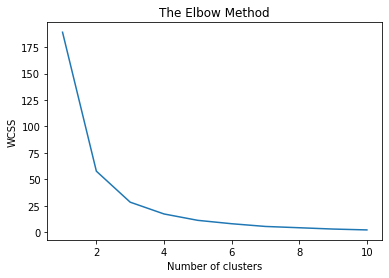

In [ ]:
wcss=[]
for i in range(1,11):
  kmeans = cluster.KMeans(n_clusters=i,init='k-means++',random_state=42)
  kmeans.fit(x)
  wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
from sklearn import metrics

In [ ]:
model = cluster.KMeans(n_clusters=6,random_state=10)
x_cluster=model.fit_predict(x)
score = metrics.silhouette_score(x,x_cluster)
print('when cluster is 6, score is:', score)

when cluster is 6, score is: 0.5675629345346325


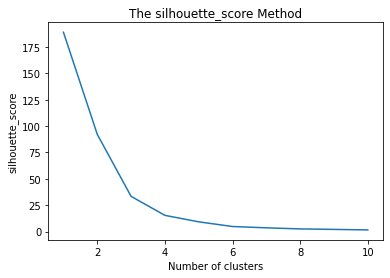

Largest silhouette score was 0.6768 for k=2


In [ ]:
y=[]
z=[]
for i in range(2,11):
  model = cluster.KMeans(n_clusters=i,random_state=10)
  x_cluster=model.fit_predict(x)
  score = metrics.silhouette_score(x,x_cluster)
  y.append(score)
  z.append(i)
plt.plot(range(1,11),wcss)
plt.title('The silhouette_score Method')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.show()
print(f"Largest silhouette score was {max(y):6.4f} for k={z[y.index(max(y))]}")

In [ ]:
centers = pd.DataFrame(model.cluster_centers_)

In [ ]:
var_clustering_2019['clusters']=model.labels_
var_clustering_2019['clusters'].value_counts(1)

0    0.576720
2    0.285714
1    0.137566
Name: clusters, dtype: float64

In [ ]:
var_clustering_2019.groupby(['clusters']).mean()

,total_complaints_number,total_population,female_percentage,white_ethic_percentage,Unemployed_percentage,Renter-occupied_rate,Less_than_high_school_graduate_percentage,disability_percentage
clusters,,,,,,,,
0,1833.750000,41.470500,52.875000,30.187500,8.300000,71.012500,15.175000,9.375000
1,6478.666667,67.177667,53.000000,24.600000,9.800000,76.500000,20.600000,9.733333
2,3220.000000,65.043000,53.800000,2.300000,16.100000,70.400000,22.000000,13.700000
3,6132.000000,72.789000,54.700000,22.000000,9.000000,84.500000,27.300000,18.600000
4,438.750000,25.350375,51.712500,47.350000,6.500000,30.825000,12.012500,9.775000
5,3330.200000,45.718000,50.400000,30.300000,9.060000,81.980000,19.400000,10.100000
6,9625.000000,79.697500,52.300000,17.450000,12.550000,89.300000,24.200000,12.100000
7,2697.875000,68.114750,52.200000,46.737500,6.312500,67.737500,17.275000,8.750000
8,844.375000,28.485875,51.450000,43.987500,6.575000,49.250000,14.325000,9.437500


In [ ]:
var_clustering_2019.groupby(['clusters']).total_complaints_number.describe()

,count,mean,std,min,25%,50%,75%,max
clusters,,,,,,,,
0,8.0,1833.750000,446.718112,1263.0,1587.75,1790.0,1929.75,2769.0
1,3.0,6478.666667,1937.601696,4759.0,5429.00,6099.0,7338.50,8578.0
2,1.0,3220.000000,NaN,3220.0,3220.00,3220.0,3220.00,3220.0
3,1.0,6132.000000,NaN,6132.0,6132.00,6132.0,6132.00,6132.0
4,8.0,438.750000,164.628369,255.0,318.00,408.0,505.50,767.0
5,5.0,3330.200000,616.950727,2519.0,2822.00,3640.0,3818.00,3852.0
6,2.0,9625.000000,185.261977,9494.0,9559.50,9625.0,9690.50,9756.0
7,8.0,2697.875000,545.489148,1938.0,2401.25,2748.5,3007.00,3555.0
8,8.0,844.375000,199.979240,562.0,649.75,929.0,986.25,1083.0


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:640: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


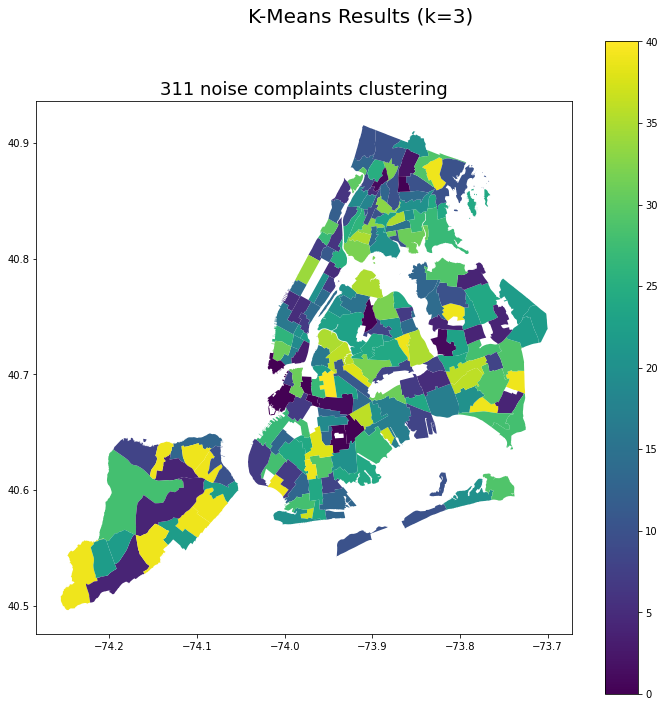

In [ ]:
#now color the NTA zones based on the number of 311 noise complaints
#from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize=(12, 12))
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.2)
fig.suptitle(f"K-Means Results (k=3)",fontsize=20,y=0.92)
ax.set_title("311 noise complaints clustering", fontsize=18)
var_clustering_2019.plot(axes=ax, column='clusters', legend = True)

#plt.savefig('./Pic 311 map in 2021',dpi=500,bbox_inches = 'tight',transparent = True)cmap='PuBu'

In [ ]:
noise_cord_2021 = nta311_2021[['ntacode','Unique_Key','geometry']]
noise_cord_2021.rename(columns = {'Unique_Key':'total_complaints_number'},inplace=True)
noise_cord_2021

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ntacode,total_complaints_number,geometry
0,BK43,1920,"POLYGON ((-73.94733 40.62917, -73.94687 40.626..."
1,BK75,7595,"POLYGON ((-73.94193 40.70073, -73.94439 40.700..."
2,BX40,5055,"POLYGON ((-73.89138 40.86170, -73.89106 40.861..."
3,BK88,1484,"POLYGON ((-73.97605 40.63128, -73.97717 40.630..."
4,BK96,2645,"POLYGON ((-73.90856 40.65210, -73.90945 40.651..."
...,...,...,...
190,BX63,7088,"POLYGON ((-73.91192 40.84326, -73.91194 40.843..."
191,QN17,3564,"POLYGON ((-73.83103 40.71434, -73.83115 40.714..."
192,QN99,2234,"MULTIPOLYGON (((-73.86523 40.57046, -73.86454 ..."
193,QN03,915,"POLYGON ((-73.75763 40.66645, -73.75756 40.666..."


In [ ]:
var_clustering_2021=pd.merge(noise_cord_2021,variables,left_on='ntacode',right_on='GeoID')
var_clustering_2021.drop('children_aged_10 to 19_percenntage', axis=1, inplace=True)
var_clustering_2021.drop('below_poverty_percentage ', axis=1, inplace=True)
var_clustering_2021.drop('GeoType', axis=1, inplace=True)
var_clustering_2021.drop('GeoID', axis=1, inplace=True)
var_clustering_2021.head()

,ntacode,total_complaints_number,geometry,GeogName,Borough,total_population,female_percentage,white_ethic_percentage,Unemployed_percentage,Renter-occupied_rate,Less_than_high_school_graduate_percentage,disability_percentage
0,BK43,1920,"POLYGON ((-73.94733 40.62917, -73.94687 40.626...",Midwood,Brooklyn,53.377,51.8,74.7,9.2,67.5,14.1,11.3
1,BK75,7595,"POLYGON ((-73.94193 40.70073, -73.94439 40.700...",Bedford,Brooklyn,75.318,51.6,35.1,12.5,81.5,21.7,10.2
2,BX40,5055,"POLYGON ((-73.89138 40.86170, -73.89106 40.861...",Fordham South,The Bronx,28.434,51.6,1.2,14.3,98.8,37.1,13.1
3,BK88,1484,"POLYGON ((-73.97605 40.63128, -73.97717 40.630...",Borough Park,Brooklyn,105.913,49.0,75.7,5.7,68.8,27.1,8.3
4,BK96,2645,"POLYGON ((-73.90856 40.65210, -73.90945 40.651...",Rugby-Remsen Village,Brooklyn,55.951,56.4,1.8,9.6,69.6,16.3,9.8


In [ ]:
from sklearn import cluster
from sklearn import metrics

In [ ]:
x1 = var_clustering_2021[['total_complaints_number']]
from sklearn.preprocessing import scale
x1 = pd.DataFrame(scale(x1))
x1.head()

,0
0,-0.443765
1,0.817092
2,0.252761
3,-0.540634
4,-0.282686


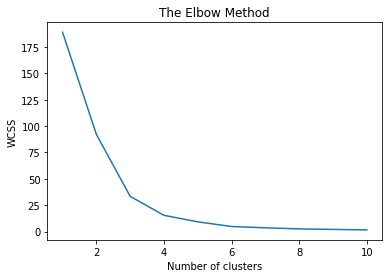

In [ ]:
wcss=[]
for i in range(1,11):
  kmeans = cluster.KMeans(n_clusters=i,init='k-means++',random_state=42)
  kmeans.fit(x1)
  wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
from sklearn import metrics

In [ ]:
model = cluster.KMeans(n_clusters=3,random_state=10)
x_cluster=model.fit_predict(x1)
score = metrics.silhouette_score(x,x_cluster)
print('when cluster is 3, score is:', score)

when cluster is 3, score is: 0.20757220067819698


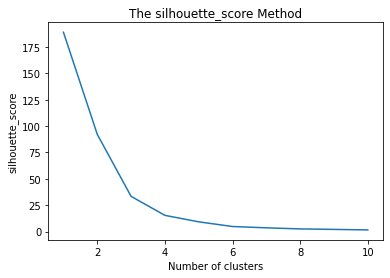

Largest silhouette score was 0.7134 for k=2


In [ ]:
y1=[]
z1=[]
for i in range(2,42):
  model = cluster.KMeans(n_clusters=i,random_state=10)
  x_cluster=model.fit_predict(x1)
  score = metrics.silhouette_score(x1,x_cluster)
  y1.append(score)
  z1.append(i)
plt.plot(range(1,11),wcss)
plt.title('The silhouette_score Method')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.show()
print(f"Largest silhouette score was {max(y1):6.4f} for k={z1[y1.index(max(y1))]}")

In [ ]:
centers = pd.DataFrame(model.cluster_centers_)

In [ ]:
var_clustering_2021['clusters']=model.labels_
var_clustering_2021['clusters'].value_counts(1)

0    0.873016
1    0.126984
Name: clusters, dtype: float64

In [ ]:
var_clustering_2021.groupby(['clusters']).mean()

,total_complaints_number,total_population,female_percentage,white_ethic_percentage,Unemployed_percentage,Renter-occupied_rate,Less_than_high_school_graduate_percentage,disability_percentage
clusters,,,,,,,,
0,2688.606061,41.017267,52.448485,34.770909,8.531515,61.737576,18.747273,10.792727
1,12364.916667,70.170958,52.129167,26.408333,10.191667,83.250000,22.025000,10.733333


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:640: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


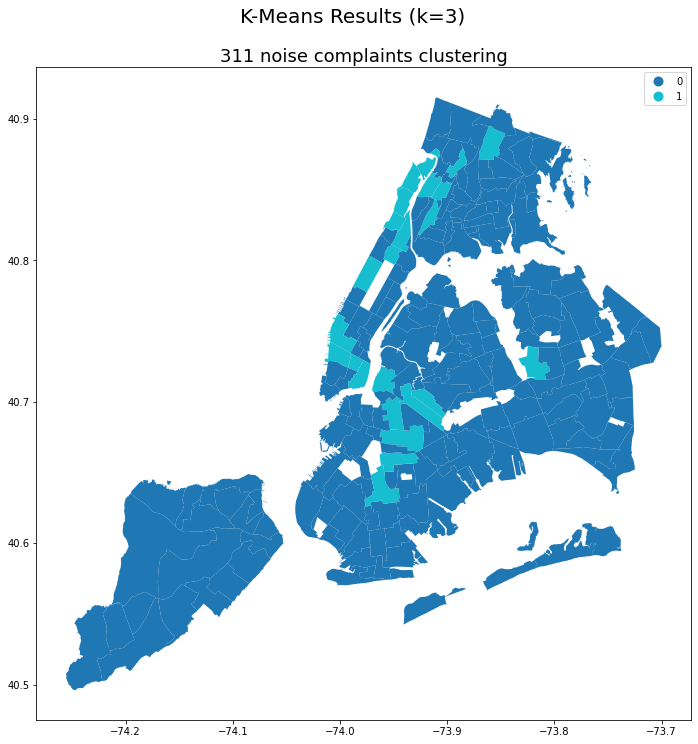

In [ ]:
#now color the NTA zones based on the number of 311 noise complaints
#from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize=(12, 12))
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.2)
fig.suptitle(f"K-Means Results (k=3)",fontsize=20,y=0.95)
ax.set_title("311 noise complaints clustering", fontsize=18)
var_clustering_2021.plot(axes=ax, column='clusters', categorical=True, legend=True)

#plt.savefig('./Pic 311 map in 2021',dpi=500,bbox_inches = 'tight',transparent = True)cmap='PuBu'